## Checkpoint

为了防止优化过程异常中断（比如计算机异常断电，用户`KeyBoardInterrupt`等），我们开发了检查点与热启动机制。检查点机制保证每迭代`checkpoint_freq`次后将优化器以`FMinResult`的形式存储在硬盘上(文件路径为`checkpoint_file`)。

In [1]:
from ultraopt import fmin, FMinResult
from ultraopt.tests.mock import config_space, evaluate
import sys
sys.tracebacklimit = 0 # limit traceback infomation

我们运行一个样例，并且在运行完之前使用`KeyboardInterrupt`将其中断：

In [2]:
result = fmin(evaluate, config_space, 
              checkpoint_file="checkout.pkl", # 检查点保存的路径
              checkpoint_freq=1,  # 保存检查点的频率，默认为 10， 为了更及时地保存优化器状态，这里设置为 1
              n_iterations=100000,  # 设置一个很大的值，运行到一半 我们中断程序
            )

  0%|          | 177/100000 [00:13<2:02:44, 13.55trial/s, best loss: 0.437]


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


KeyboardInterrupt: 

因为如果在保存`checkpoint_file`的时候中断的话会导致检查点文件不完整，UltraOpt的机制是会形成检查点备份文件：

In [3]:
!ls -lh *.pkl *.bak

-rw-r--r-- 1 tqc tqc 699K 12月 29 12:15 checkout.pkl
-rw-r--r-- 1 tqc tqc 699K 12月 29 12:15 checkout.pkl.bak


In [4]:
from joblib import load

如果加载保存不完整的检查点文件，会报错

In [5]:
result = load("checkout.pkl")

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
EOFError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'EOFError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


EOFError: 

但我们可以加载检查点备份文件：

In [8]:
checkout_content = load("checkout.pkl.bak")

检查点保存的内容本质上是**优化器**, UltraOpt的设计哲学是以优化器为中心，优化器承载了优化过程中的全部状态，所以我们只需要在检查点中保存优化器 :

In [9]:
type(checkout_content)

ultraopt.optimizer.bo.etpe_opt.ETPEOptimizer

我们可以用`ultraopt.FMinResult`这个数据结构包装优化器，这个数据结构也是`ultraopt.fmin`的返回值：

In [20]:
result = FMinResult(checkout_content)

对于加载得到的`FMinResult`，我们可以像之前的教程一样对**优化结果**和**优化过程**进行数据分析：

In [21]:
result

+---------------------------------+
| HyperParameters | Optimal Value |
+-----------------+---------------+
| x0              | 0.3409        |
| x1              | 0.1209        |
+-----------------+---------------+
| Optimal Loss    | 0.4366        |
+-----------------+---------------+
| Num Configs     | 176           |
+-----------------+---------------+

随迭代数的拟合曲线

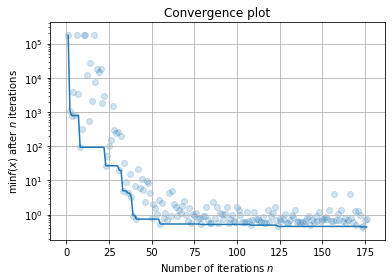

In [22]:
result.plot_convergence(yscale="log");

随时间的拟合曲线

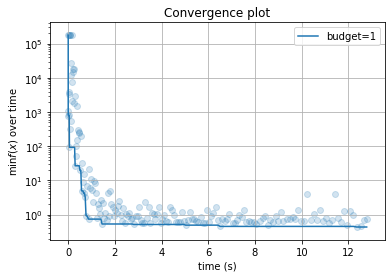

In [23]:
result.plot_convergence_over_time(yscale="log");

随时间的运行数

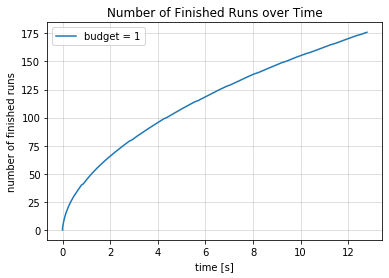

In [24]:
result.plot_finished_over_time();

## Warmstart

在优化过程异常中断后，如果我们想重启优化过程，需要指定之前的运行结果：`previous_result`参数

In [25]:
result = fmin(evaluate, config_space, 
              checkpoint_file="checkout.pkl",
              checkpoint_freq=1,  
              previous_result="checkout.pkl.bak", # 之前的运行结果
              n_iterations=20,  # 只运行20次
            )

100%|██████████| 20/20 [00:03<00:00,  6.20trial/s, best loss: 0.437]


我们看到虽然只运行了20次，但是之前的优化过程都是有记录的：

In [30]:
result

+---------------------------------+
| HyperParameters | Optimal Value |
+-----------------+---------------+
| x0              | 0.3409        |
| x1              | 0.1209        |
+-----------------+---------------+
| Optimal Loss    | 0.4366        |
+-----------------+---------------+
| Num Configs     | 215           |
+-----------------+---------------+

**随时间的运行数**曲线也可以正常绘制，各种图表反映了中断前和恢复后的状态：

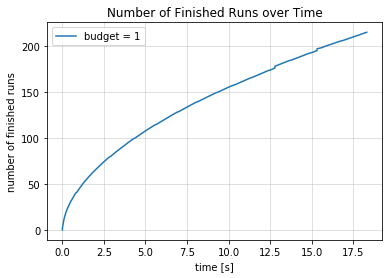

In [28]:
result.plot_finished_over_time();

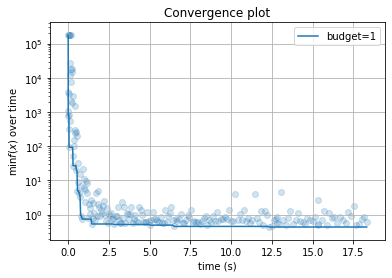

In [29]:
result.plot_convergence_over_time(yscale="log");